## Broken Power Law Examples

Below are a few examples of the broken power law rating curve implementation.

In [1]:
from numpy.typing import ArrayLike
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import sys

if ".." not in sys.path:
    sys.path.insert(0, "..")

Equation for a broken power law with $n$ breaks is:

\begin{equation}
f(x) = \begin{cases}
            Ax^{\alpha_0} & {\rm if}\ x \leq x_1 \\
            Ax^{\alpha_1}x_1^{\alpha_0 - \alpha_1} & {\rm if}\ x_1 < x \leq x_2 \\
            ... \\
            Ax^{\alpha_n} {\displaystyle \prod^{n}_{i=1}} x_i^{\alpha_{i-1} - \alpha_{i}} & {\rm if}\ x > x_n
       \end{cases},
\end{equation}

where $A$ is the scaling amplitude, $\alpha_0$ is the power law slope before the first breakpoint ($x_1$), $\alpha_i$ are the power law slopes between breakpoints $x_{i}$ and $x_{i+1}$ with $i$ being the $i$th breakpoint and $i < n$, and $\alpha_n$ is the power law slope after the last breakpoint ($x_n$).

In log-space this translates to:

\begin{equation}
\log(f(x)) = \begin{cases}
            \log(A) + \alpha_0 \log(x) & {\rm if}\ x \leq x_1 \\
            \log(A) + \alpha_1 \log(x) + (\alpha_0 - \alpha_1) \log(x_1) & {\rm if}\ x_1 < x \leq x_2 \\
            ... \\
            \log(A) + \alpha_n \log(x) + {\displaystyle \sum^{n}_{i=1}} (\alpha_{i-1} - \alpha_{i}) \log(x_i) & {\rm if}\ x > x_n
       \end{cases}.
\end{equation}

In [2]:
def BrokenPowerLaw(x: ArrayLike, amplitude: float, breaks: ArrayLike, alphas: ArrayLike) -> np.ndarray:
    x = np.array(x)
    alphas_array = np.array(alphas)
    cumprod = np.cumprod(breaks ** (alphas_array[:-1] - alphas_array[1:]))
    # Product for first element is 1, as it does not have a product
    cumprod = np.insert(cumprod, 0, 1).reshape((-1, 1))
    # Create ranges for each segment
    segments_range = np.insert(breaks, [0, len(breaks)], [0.0, np.inf]).reshape((-1, 1))

    # Arrays are broadcasts for vectorized computation. Calculates function within range sets value to 0 everywhere else. 
    #   Then sum along segment dimension to collapse.
    fx = np.where((x > segments_range[:-1]) & (x <= segments_range[1:]), 
                  amplitude * x ** alphas_array.reshape((-1, 1)) * cumprod, 0)
    fx = fx.sum(axis=0)
    
    return fx

Now that we have created to equation function, let's generate some simulated data.

<function matplotlib.pyplot.show(close=None, block=None)>

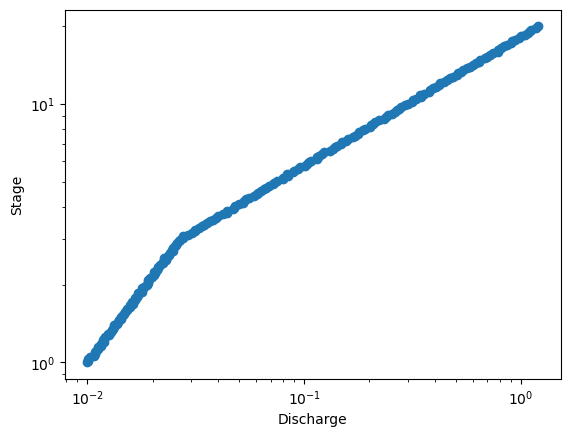

In [3]:
h = np.geomspace(1, 20, 201)
a = 0.01
breaks = [3.0]
alphas = [0.9, 2]
q = BrokenPowerLaw(h, a, breaks, alphas)
# Add some random noise in log space
q = np.exp(np.log(q) + np.random.randn(len(q)) * 0.01)

fig, ax = plt.subplots()
ax.loglog(q, h, marker='o', linestyle='')
ax.set(xlabel='Discharge', ylabel='Stage')
plt.show

Then fit the simulated data and plot the fits.

In [4]:
from ratingcurve.experimental import BrokenPowerLawRating

# initialize the model
brokenpowerrating = BrokenPowerLawRating(q=q,
                                         h=h, 
                                         segments=2,)
trace = brokenpowerrating.fit()
data = brokenpowerrating.table(trace, h)

Convergence achieved at 53600
Interrupted at 53,599 [26%]: Average Loss = 3.8039e+06


<function matplotlib.pyplot.show(close=None, block=None)>

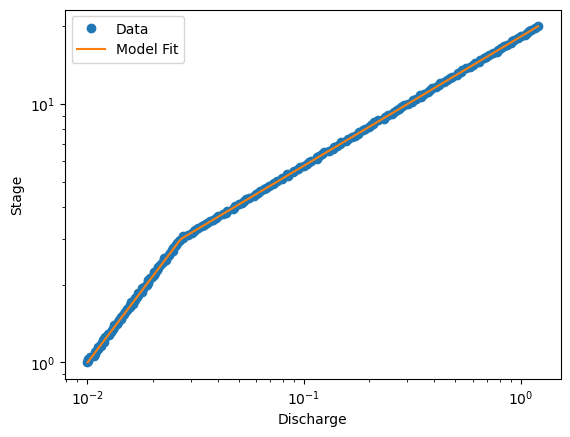

In [5]:
fig, ax = plt.subplots()
ax.loglog(q, h, marker='o', linestyle='', label='Data')
ax.loglog(data['discharge'], data['stage'], label='Model Fit')
ax.set(xlabel='Discharge', ylabel='Stage')
plt.legend()
plt.show

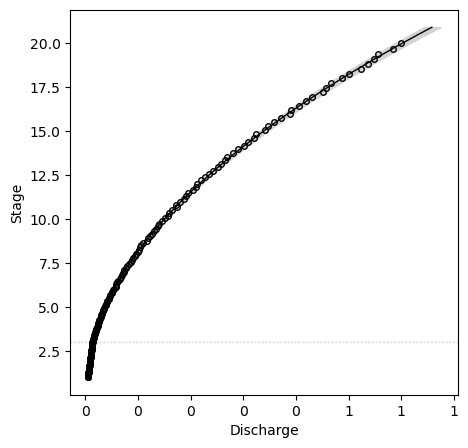

In [6]:
brokenpowerrating.plot(trace)

In [7]:
print('Power law slopes expected values: '+str(alphas)+', Derived values: '
      +str(trace.posterior.w.mean(axis=1).values.squeeze())+' +/- '+str(trace.posterior.w.std(axis=1).values.squeeze()))
print('Break point expected values: '+str(breaks)+', Derived values: '
      +str(trace.posterior.hs.mean(axis=1).values.squeeze())+' +/- '+str(trace.posterior.hs.std(axis=1).values.squeeze()))
print('Normalization expected values: '+str(a)+', Derived values: '
      +str(np.exp(trace.posterior.a.mean().values.squeeze()))+' +/- '+str(np.exp(trace.posterior.a.mean().values.squeeze()) * trace.posterior.a.std().values.squeeze()))

Power law slopes expected values: [0.9, 2], Derived values: [0.90065993 2.00208963] +/- [0.0013166  0.00130833]
Break point expected values: [3.0], Derived values: 3.004690987132028 +/- 0.004326295946256724
Normalization expected values: 0.01, Derived values: 0.010039898027597879 +/- 1.2550137943652923e-05


Let's see how this fit compares with the original power law rating.

In [8]:
from ratingcurve.ratingmodel import PowerLawRating

powerrating = PowerLawRating(q=q,
                             h=h, 
                             segments=2)
trace_pl = powerrating.fit()
data_pl = powerrating.table(trace_pl, h)

Convergence achieved at 70300
Interrupted at 70,299 [35%]: Average Loss = 3,060.9


<function matplotlib.pyplot.show(close=None, block=None)>

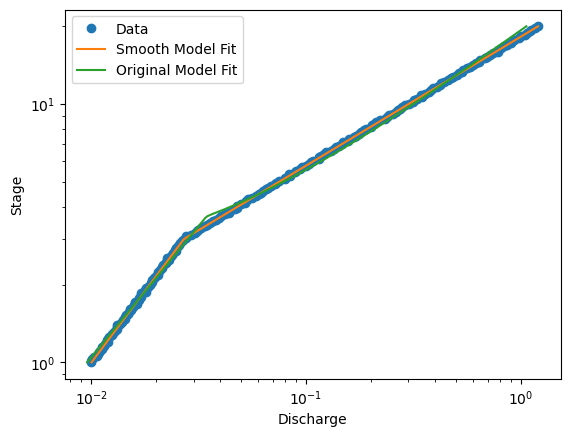

In [9]:
fig, ax = plt.subplots()
ax.loglog(q, h, marker='o', linestyle='', label='Data')
ax.loglog(data['discharge'], data['stage'], label='Smooth Model Fit')
ax.loglog(data_pl['discharge'], data_pl['stage'], label='Original Model Fit')
ax.set(xlabel='Discharge', ylabel='Stage')
plt.legend()
plt.show

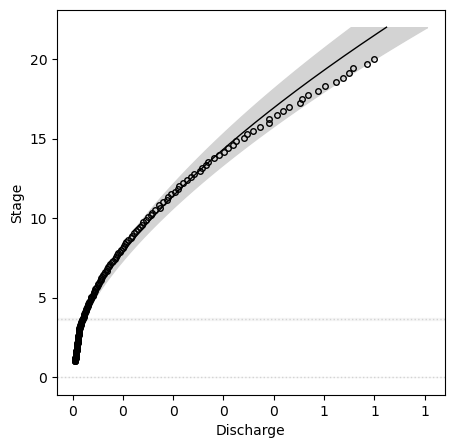

In [10]:
powerrating.plot(trace_pl)

In [11]:
print('Break point expected values: '+str(breaks)+', Derived values: '
      +str(trace_pl.posterior.hs.mean(axis=1).values.squeeze())+' +/- '+str(trace_pl.posterior.hs.std(axis=1).values.squeeze()))

Break point expected values: [3.0], Derived values: [0.00629019 3.67919289] +/- [0.00586606 0.03394035]


The original power law model fit the data pretty well considering it was not used to generate the data like the smooth power law model. Now let's test both models on some real data to see how they compare on something less bias toward a certain model.

<function matplotlib.pyplot.show(close=None, block=None)>

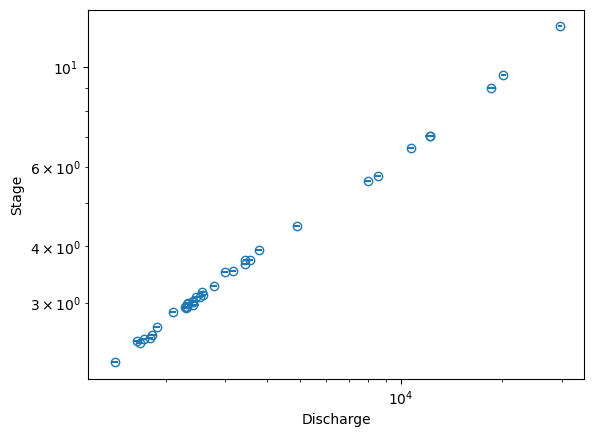

In [12]:
from ratingcurve import data

# load tutorial data
df = data.load('green channel')

fig, ax = plt.subplots()
ax.errorbar(df['q'], df['stage'], xerr=df['q_sigma'], marker='o', linestyle='', fillstyle='none')
ax.set(xlabel='Discharge', ylabel='Stage', xscale='log', yscale='log')
plt.show

In [13]:
# initialize the model
brokenpowerrating_gc = BrokenPowerLawRating(q=df['q'],
                                            h=df['stage'], 
                                            q_sigma=df['q_sigma'],
                                            segments=2)
trace_gc = brokenpowerrating_gc.fit()
data_gc = brokenpowerrating_gc.table(trace_gc, np.geomspace(df['stage'].min(), df['stage'].max(), 201))

Convergence achieved at 57400
Interrupted at 57,399 [28%]: Average Loss = 1.4215e+05


In [14]:
# initialize the model
powerrating_gc = PowerLawRating(q=df['q'],
                                h=df['stage'], 
                                q_sigma=df['q_sigma'],
                                segments=2)
trace_pl_gc = powerrating_gc.fit()
data_pl_gc = powerrating_gc.table(trace_pl_gc, np.geomspace(df['stage'].min(), df['stage'].max(), 201))

Convergence achieved at 69500
Interrupted at 69,499 [34%]: Average Loss = 16.471


<function matplotlib.pyplot.show(close=None, block=None)>

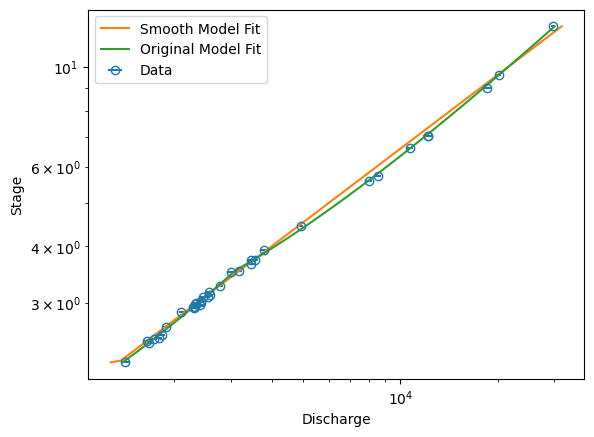

In [15]:
fig, ax = plt.subplots()
ax.errorbar(df['q'], df['stage'], xerr=df['q_sigma'], marker='o', linestyle='', fillstyle='none', label='Data')
ax.loglog(data_gc['discharge'], data_gc['stage'], label='Smooth Model Fit')
ax.loglog(data_pl_gc['discharge'], data_pl_gc['stage'], label='Original Model Fit')
ax.set(xlabel='Discharge', ylabel='Stage', xscale='log', yscale='log')
plt.legend()
plt.show

In [16]:
print('Power law slopes derived values: '
      +str(trace_gc.posterior.w.mean(axis=1).values.squeeze())+' +/- '+str(trace_gc.posterior.w.std(axis=1).values.squeeze()))
print('Break point derived values: '
      +str(trace_gc.posterior.hs.mean(axis=1).values.squeeze())+' +/- '+str(trace_gc.posterior.hs.std(axis=1).values.squeeze()))

Power law slopes derived values: [15.9714039   1.83680448] +/- [0.00997316 0.01163405]
Break point derived values: 2.2187041202491184 +/- 0.0010980012451086135


In [17]:
print('Break point derived values: '
      +str(trace_pl_gc.posterior.hs.mean(axis=1).values.squeeze())+' +/- '+str(trace_pl_gc.posterior.hs.std(axis=1).values.squeeze()))

Break point derived values: [0.86046764 3.53503129] +/- [0.00778801 0.0454793 ]


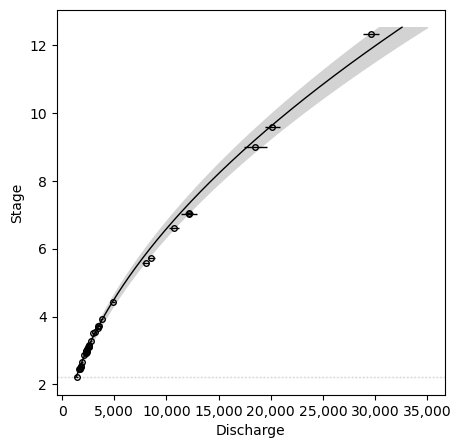

In [18]:
brokenpowerrating_gc.plot(trace_gc)

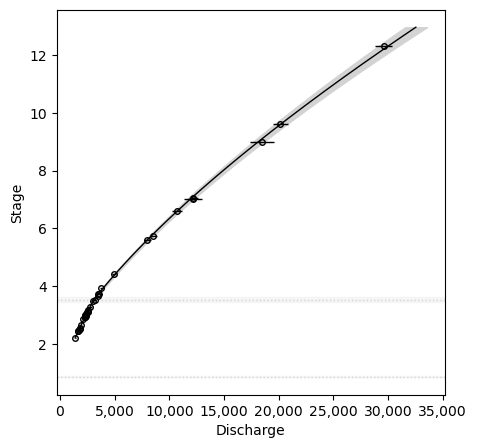

In [19]:
powerrating_gc.plot(trace_pl_gc)